In [14]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [15]:
from datetime import date
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import linear_model, tree
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import ensemble
from sklearn.decomposition import PCA

In [16]:
def get_names(dataframe):
    cols = dataframe.columns
    s = set()
    for col in cols:
        s.add(col[:col.find("_")])
    return list(s)

In [17]:
data = pd.read_csv("./data.csv")

In [18]:
data.reindex_axis(sorted(data.columns), axis=1)
data.set_index("Date", inplace=True)
data.index = pd.to_datetime(data.index)
data.sort_index(inplace=True)

In [19]:
all_stocks = get_names(data)
#use_stocks = ["GOOGL", "AAPL", "NFLX", "AMZN", "QCOM", "SBUX"]
use_stocks = ["SPY", "USB", "JPM", "MSFT", "CAT"]

In [20]:
def select_stocks(dataframe, stocks, suffix = "_Cls%"):
    transformed = list(map(lambda x : x + suffix, stocks))
    selected = dataframe[transformed]
    selected.columns = stocks
    return selected

In [21]:
selected = select_stocks(data, use_stocks)
selected_all = select_stocks(data, all_stocks)

In [22]:
dataset = selected.tail(1100)

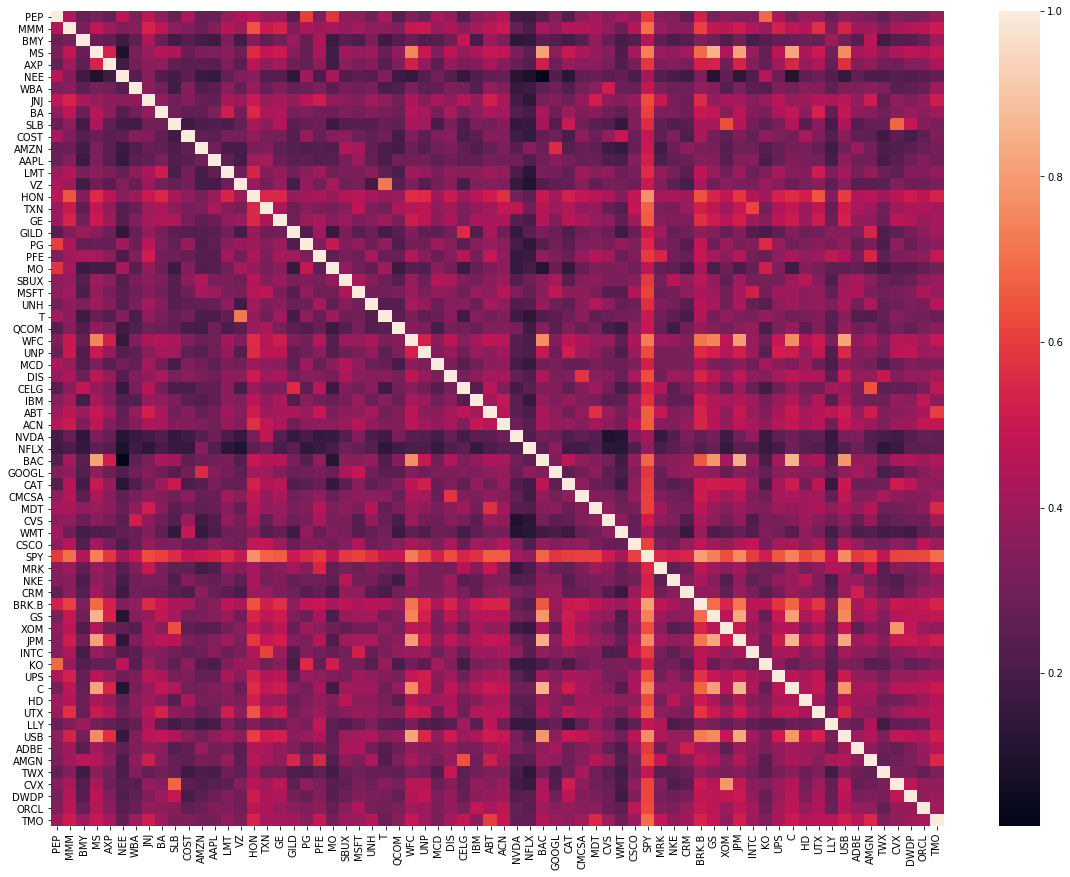

In [23]:
corr = selected_all.tail(1100).corr()
plt.subplots(figsize=(20,15))
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [24]:
dataset.corr()

,SPY,USB,JPM,MSFT,CAT
SPY,1.000000,0.765861,0.759878,0.614661,0.601578
USB,0.765861,1.000000,0.829854,0.417971,0.497563
JPM,0.759878,0.829854,1.000000,0.422293,0.503763
MSFT,0.614661,0.417971,0.422293,1.000000,0.356486
CAT,0.601578,0.497563,0.503763,0.356486,1.000000


In [233]:
n_names = len(dataset.columns)
raw_dataset = dataset.tail(1000)
raw_outputs = raw_dataset.as_matrix()
feature_ma2 = dataset.rolling(window = 2, center=False).mean().tail(1000)
feature_ma3 = dataset.rolling(window = 3, center=False).mean().tail(1000)
feature_ma5 = dataset.rolling(window = 5, center=False).mean().tail(1000)
feature_ma10 = dataset.rolling(window = 10, center=False).mean().tail(1000)
feature_ma30 = dataset.rolling(window = 30, center=False).mean().tail(1000)

feature_mstd30 = dataset.rolling(window = 30, center=False).mean().tail(1000)

features = np.hstack([feature_ma2, feature_ma3, feature_ma5])

1 - linear regression model =)

In [234]:
#features_lin = np.vstack([feature_ma2["SPY"], feature_ma3["SPY"], feature_ma5["SPY"], feature_ma10["SPY"], feature_ma30["SPY"]]).reshape((1000,-1))
features_lin = features
X_train_lin, X_test_lin, y_train_lin, y_test_lin=train_test_split(features_lin, raw_outputs, test_size = 0.2, shuffle=False)

In [235]:
lin_model = linear_model.LinearRegression(fit_intercept=True)

In [236]:
lin_model.fit(X_train_lin, y_train_lin)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [237]:
y_train_prediction_lin = lin_model.predict(X_train_lin)

train dataset scores

In [238]:
print(r2_score(y_train_lin, y_train_prediction_lin, multioutput = "raw_values"))
print(mean_squared_error(y_train_lin, y_train_prediction_lin, multioutput = "raw_values"))

[ 0.53416643  0.50748435  0.50926601  0.51175516  0.49484289]
[ 0.31738613  0.64905344  0.90327198  1.03874255  1.13990065]


In [239]:
y_test_prediction_lin = lin_model.predict(X_test_lin)

In [240]:
print(r2_score(y_test_lin, y_test_prediction_lin, multioutput = "raw_values"))
print(mean_squared_error(y_test_lin, y_test_prediction_lin, multioutput = "raw_values"))

[ 0.39243012  0.46745818  0.48447999  0.46428209  0.47896582]
[ 0.11181326  0.37217987  0.48279953  0.44112174  0.924561  ]


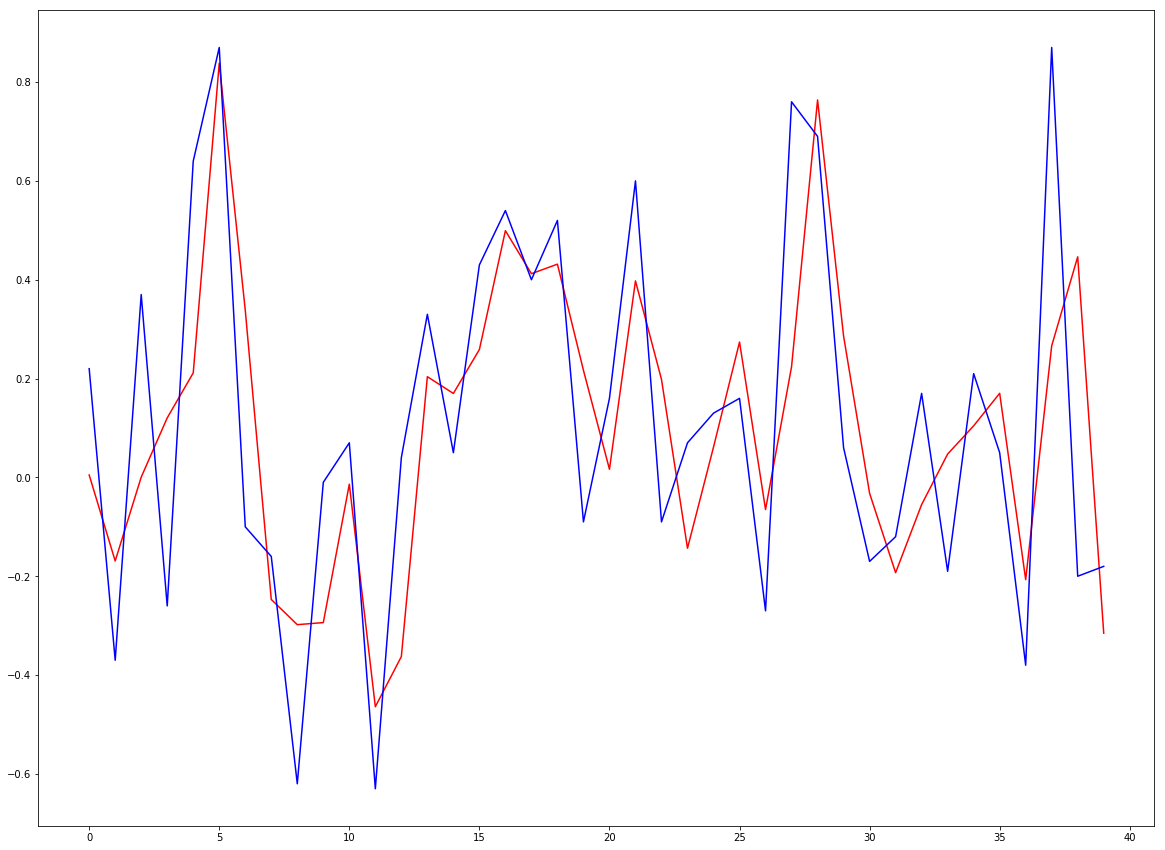

In [241]:
plt.subplots(figsize=(20,15))
plt.plot(y_test_prediction_lin[:40, 0], 'r')
plt.plot(y_test_lin[:40,0], 'b')

NN

In [148]:
import tensorflow as tf

In [149]:
import os
os.environ["TF_CPP_MIN_VLOG_LEVEL"]="3"

In [199]:
use_stocks

['SPY', 'USB', 'JPM', 'MSFT', 'CAT']

In [254]:
current_name = 'SPY'
current_outputs = raw_dataset[current_name].as_matrix()
nn_ma2 = dataset[current_name].rolling(window = 2, center=False).mean().tail(1000).as_matrix()
nn_ma3 = dataset[current_name].rolling(window = 3, center=False).mean().tail(1000).as_matrix()
nn_ma5 = dataset[current_name].rolling(window = 5, center=False).mean().tail(1000).as_matrix()
nn_ma10 = dataset[current_name].rolling(window = 10, center=False).mean().tail(1000).as_matrix()
nn_ma20 = dataset[current_name].rolling(window = 20, center=False).mean().tail(1000).as_matrix()

nn_ma2_train, nn_ma2_test, nn_ma3_train, nn_ma3_test, nn_ma5_train, nn_ma5_test, ytrainNN, ytestNN = train_test_split(nn_ma2, nn_ma3, nn_ma5, current_outputs, test_size = 0.2, shuffle=False)

In [255]:
def get_input_fn(X, X_labels, y = None, num_epochs=None, shuffle=False):
    return tf.estimator.inputs.numpy_input_fn(
      x = dict(zip(X_labels, X)),
      y = y,
      num_epochs=num_epochs,
      shuffle=shuffle)

In [256]:
nn_feature_ma2  = tf.contrib.layers.real_valued_column("ma2")
nn_feature_ma3  = tf.contrib.layers.real_valued_column("ma3")
nn_feature_ma5  = tf.contrib.layers.real_valued_column("ma5")
nn_features_list = [
    nn_feature_ma2
    ,nn_feature_ma3
    ,nn_feature_ma5
    #,nn_feature_ma10
    #,nn_feature_ma20
]
nn_feature_labels = ["ma2", "ma3", "ma5"]

In [257]:
model_dnn_config = tf.estimator.RunConfig()
model_dnn_config.replace(save_summary_steps = 1000)
model_dnn_config.replace(log_step_count_steps = 1000)
model_dnn = tf.estimator.DNNLinearCombinedRegressor(
    linear_feature_columns = nn_features_list
    ,dnn_feature_columns = nn_features_list
    
    ,linear_optimizer=tf.train.RMSPropOptimizer(0.01)
    
    ,dnn_hidden_units = [60, 120, 20]
    #,dnn_hidden_units = [5, 20, 25, 50, 15,10,10,25,10,5]
    ,dnn_dropout = 0.05
    ,config = model_dnn_config
)

INFO:tensorflow:Using config: {'_model_dir': 'D:\\Temp\\SYSTEM\\tmp85y30lr0', '_tf_random_seed': 1, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100}


In [258]:
train_input = get_input_fn( [nn_ma2_train, nn_ma3_train, nn_ma5_train] ,nn_feature_labels , y = ytrainNN)
train_test_input = get_input_fn( [nn_ma2_train, nn_ma3_train, nn_ma5_train] ,nn_feature_labels , y = ytrainNN, num_epochs=1)
test_input = get_input_fn( [nn_ma2_test, nn_ma3_test, nn_ma5_test] ,nn_feature_labels , y = ytestNN, num_epochs=1)

In [259]:
model_dnn.train(train_input, steps = 2000)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into D:\Temp\SYSTEM\tmp85y30lr0\model.ckpt.
INFO:tensorflow:loss = 48.2905, step = 1
INFO:tensorflow:global_step/sec: 788.41
INFO:tensorflow:loss = 24.5634, step = 101 (0.128 sec)
INFO:tensorflow:global_step/sec: 863.498
INFO:tensorflow:loss = 23.9219, step = 201 (0.116 sec)
INFO:tensorflow:global_step/sec: 834.598
INFO:tensorflow:loss = 24.3279, step = 301 (0.120 sec)
INFO:tensorflow:global_step/sec: 801.076
INFO:tensorflow:loss = 24.2044, step = 401 (0.124 sec)
INFO:tensorflow:global_step/sec: 817.493
INFO:tensorflow:loss = 23.8728, step = 501 (0.122 sec)
INFO:tensorflow:global_step/sec: 794.693
INFO:tensorflow:loss = 23.6308, step = 601 (0.126 sec)
INFO:tensorflow:global_step/sec: 776.141
INFO:tensorflow:loss = 24.1032, step = 701 (0.128 sec)
INFO:tensorflow:global_step/sec: 639.315
INFO:tensorflow:loss = 23.7242, step = 801 (0.157 sec)
INFO:tensorflow:global_step/sec: 730.663
INFO:tensorflow:loss =

In [260]:
dnn_pred = model_dnn.predict( input_fn = test_input)
dnn_predictions_arr = np.array([p["predictions"] for p in dnn_pred])
dnn_predictions_arr = dnn_predictions_arr.reshape((-1))

dnn_train_pred = model_wtf.predict( input_fn = train_test_input)
dnn_train_predictions_arr = np.array([p["predictions"] for p in dnn_train_pred])
dnn_train_predictions_arr = dnn_train_predictions_arr.reshape((-1))

INFO:tensorflow:Restoring parameters from D:\Temp\SYSTEM\tmp85y30lr0\model.ckpt-2000
INFO:tensorflow:Restoring parameters from D:\Temp\SYSTEM\tmp43189xuw\model.ckpt-6000


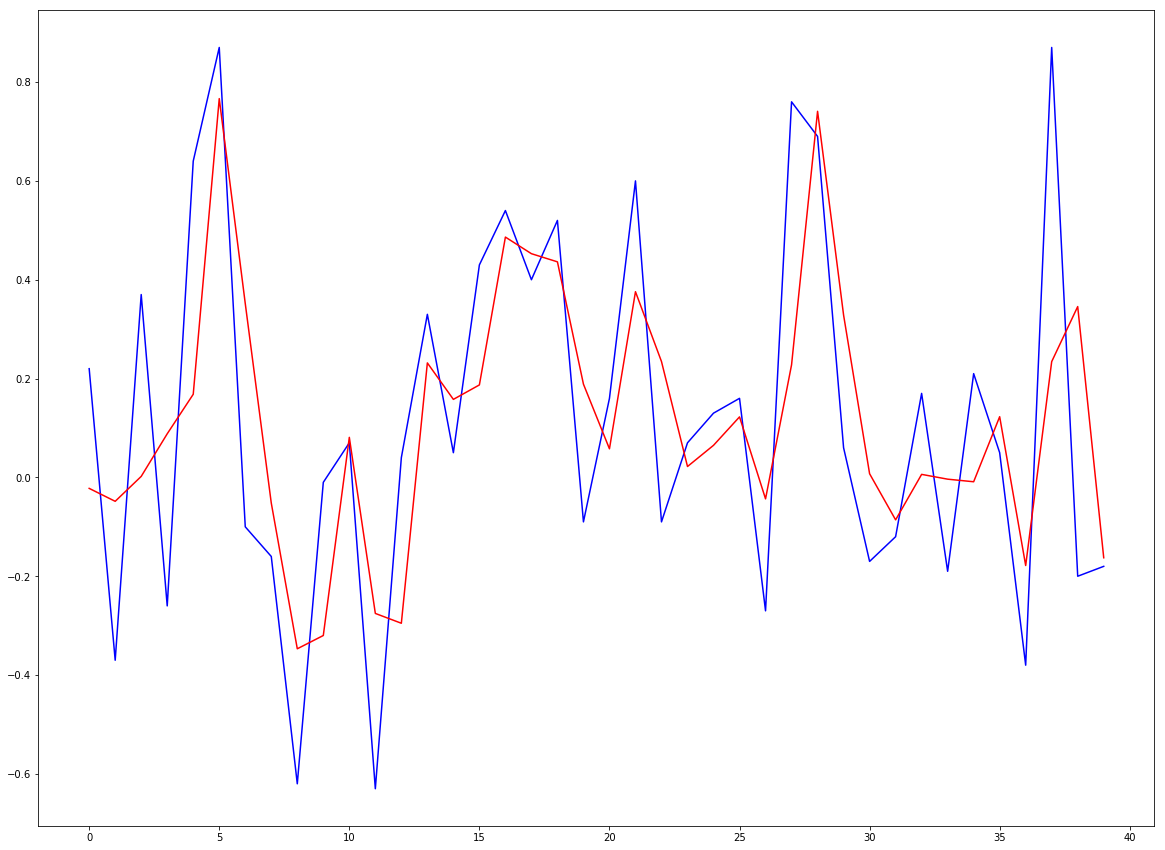

In [261]:
plt.subplots(figsize=(20,15))
plt.plot(ytestNN[:40], 'b')
plt.plot(wtf_predictions_arr[:40], 'r')
#plt.plot(y_test_prediction_lin[:40, 0], 'y')

In [224]:
print(r2_score(ytrainNN, dnn_train_predictions_arr, multioutput = "raw_values"))
print(mean_squared_error(ytrainNN, dnn_train_predictions_arr, multioutput = "raw_values"))
print('#'*20)
print(r2_score(ytestNN, dnn_predictions_arr, multioutput = "raw_values"))
print(mean_squared_error(ytestNN, dnn_predictions_arr, multioutput = "raw_values"))

[ 0.47740322]
[ 1.17925373]
####################
[ 0.46718419]
[ 0.94546719]


In [242]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa as tsa

In [253]:
for i in range(5):
    rlm_mnodel = sm.RLM( y_train_lin[:,i], X_train_lin , M=sm.robust.norms.AndrewWave())
    rlm_result = rlm_mnodel.fit()
    pred_train = rlm_result.predict(X_train_lin)
    pred_test = rlm_result.predict(X_test_lin)


    print(r2_score(y_train_lin[:,i], pred_train, multioutput = "raw_values"))
    print(mean_squared_error(y_train_lin[:,i], pred_train, multioutput = "raw_values"))
    print('#'*10)
    print(r2_score(y_test_lin[:,i], pred_test, multioutput = "raw_values"))
    print(mean_squared_error(y_test_lin[:,i], pred_test, multioutput = "raw_values"))
    print('#'*20)

[ 0.53016137]
[ 0.3201149]
##########
[ 0.4236834]
[ 0.10606161]
####################
[ 0.505368]
[ 0.65184243]
##########
[ 0.48036966]
[ 0.36315636]
####################
[ 0.50655844]
[ 0.90825569]
##########
[ 0.49230044]
[ 0.47547545]
####################
[ 0.50693544]
[ 1.04899652]
##########
[ 0.46205395]
[ 0.44295644]
####################
[ 0.49207475]
[ 1.14614702]
##########
[ 0.48246044]
[ 0.91835989]
####################


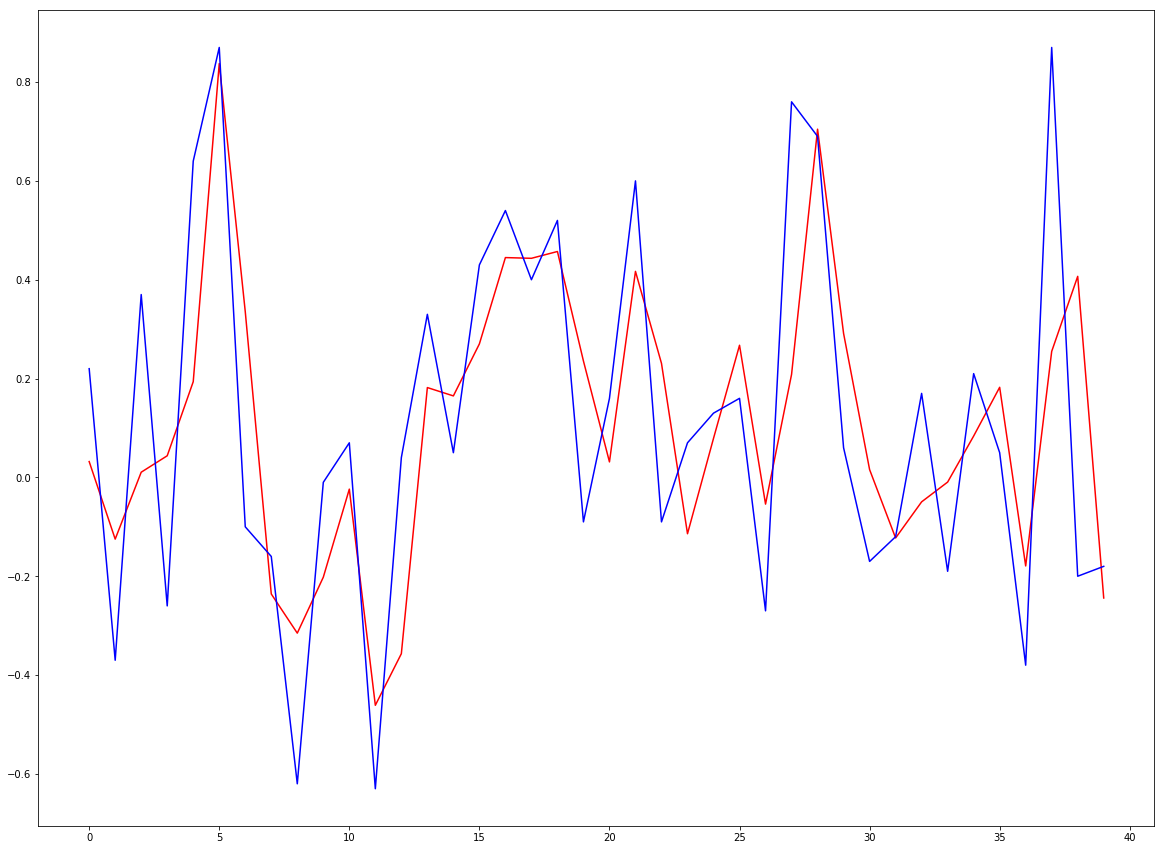

In [251]:
plt.subplots(figsize=(20,15))
plt.plot(pred_test[:40], 'r')
plt.plot(y_test_lin[:40,0], 'b')